In [ ]:
!gdown https://drive.google.com/uc?id=12eLpzedwOVNohWix_k7LDIoUaTGcqJ4Z

Downloading...
From (original): https://drive.google.com/uc?id=12eLpzedwOVNohWix_k7LDIoUaTGcqJ4Z
From (redirected): https://drive.google.com/uc?id=12eLpzedwOVNohWix_k7LDIoUaTGcqJ4Z&confirm=t&uuid=580d5ff9-cffd-48a4-8f50-0c4054b8c902
To: /content/tiny-imagenet-200.zip
100% 248M/248M [00:01<00:00, 137MB/s]


In [ ]:
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, embed_size)

    def forward(self, images):
        return self.model(images)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, embed_size):
        super(TextEncoder, self).__init__()
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.fc = nn.Linear(self.model.config.hidden_size, embed_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state[:, 0, :]
        return self.fc(hidden_states)

In [ ]:
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    image_embeddings = F.normalize(image_embeddings, dim=-1)
    text_embeddings = F.normalize(text_embeddings, dim=-1)

    logits = torch.matmul(image_embeddings, text_embeddings.T) / temperature
    labels = torch.arange(len(image_embeddings)).to(image_embeddings.device)

    loss_img = F.cross_entropy(logits, labels)
    loss_text = F.cross_entropy(logits.T, labels)

    return (loss_img + loss_text) / 2

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for class_folder in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_folder)
            if os.path.isdir(class_path):
                for img_file in os.listdir(os.path.join(class_path, 'images')):
                    img_path = os.path.join(class_path, 'images', img_file)
                    self.image_paths.append(img_path)
                    self.labels.append(class_folder)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = TinyImageNetDataset(root_dir='tiny-imagenet-200/train', transform=transform)

train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

In [ ]:
print(f"Number of training samples: {len(train_subset)}")
print(f"Number of validation samples: {len(val_subset)}")

Number of training samples: 80000
Number of validation samples: 20000


In [ ]:
def load_class_names(filepath='/content/tiny-imagenet-200/words.txt'):
    class_name_mapping = {}
    with open(filepath, 'r') as f:
        for line in f:
            wn_id, class_name = line.strip().split('\t')
            class_name_mapping[wn_id] = class_name
    return class_name_mapping

class_name_mapping = load_class_names()

['cockroach, roach', 'albatross, mollymawk', 'organ, pipe organ', 'wok', 'hourglass', 'bullfrog, Rana catesbeiana', 'computer keyboard, keypad', 'meat loaf, meatloaf', 'walking stick, walkingstick, stick insect', 'oboe, hautboy, hautbois', 'military uniform', 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'dam, dike, dyke', 'torch', 'sock', 'refrigerator, icebox', 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'nail', 'broom', 'pizza, pizza pie', 'trolleybus, trolley coach, trackless trolley', 'Persian cat', 'German shepherd, German shepherd dog, German police dog, alsatian', 'beer bottle', 'bannister, banister, balustrade, balusters, handrail', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'ox', 'volleyball', 'sandal', 'drumstick', 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'tarantula', 'baboon', 'orange', 'iPod', 'suspension bridge', 'beach wagon, station wagon, wagon, estate car

Class names: ['sewing machine', 'walking stick, walkingstick, stick insect', 'umbrella', 'drumstick', 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'wooden spoon', 'ice cream, icecream', 'beer bottle', 'centipede', 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'lampshade, lamp shade', 'military uniform', 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'viaduct', 'acorn', 'brain coral', 'dining table, board', 'remote control, remote', 'potpie', 'jellyfish', 'ox', 'tabby, tabby cat', 'barrel, cask', 'torch', 'orange', 'go-kart', 'birdhouse', 'king penguin, Aptenodytes patagonica', 'brass, memorial tablet, plaque', 'organ, pipe organ', 'pole', 'Arabian camel, dromedary, Camelus dromedarius', 'broom', 'umbrella', 'standard poodle', 'hourglass', 'meat loaf, meatloaf', 'butcher shop, meat market', 'guacamole', 'moving van', 'bikini, two-piece', 'lion, king of beasts, Panther

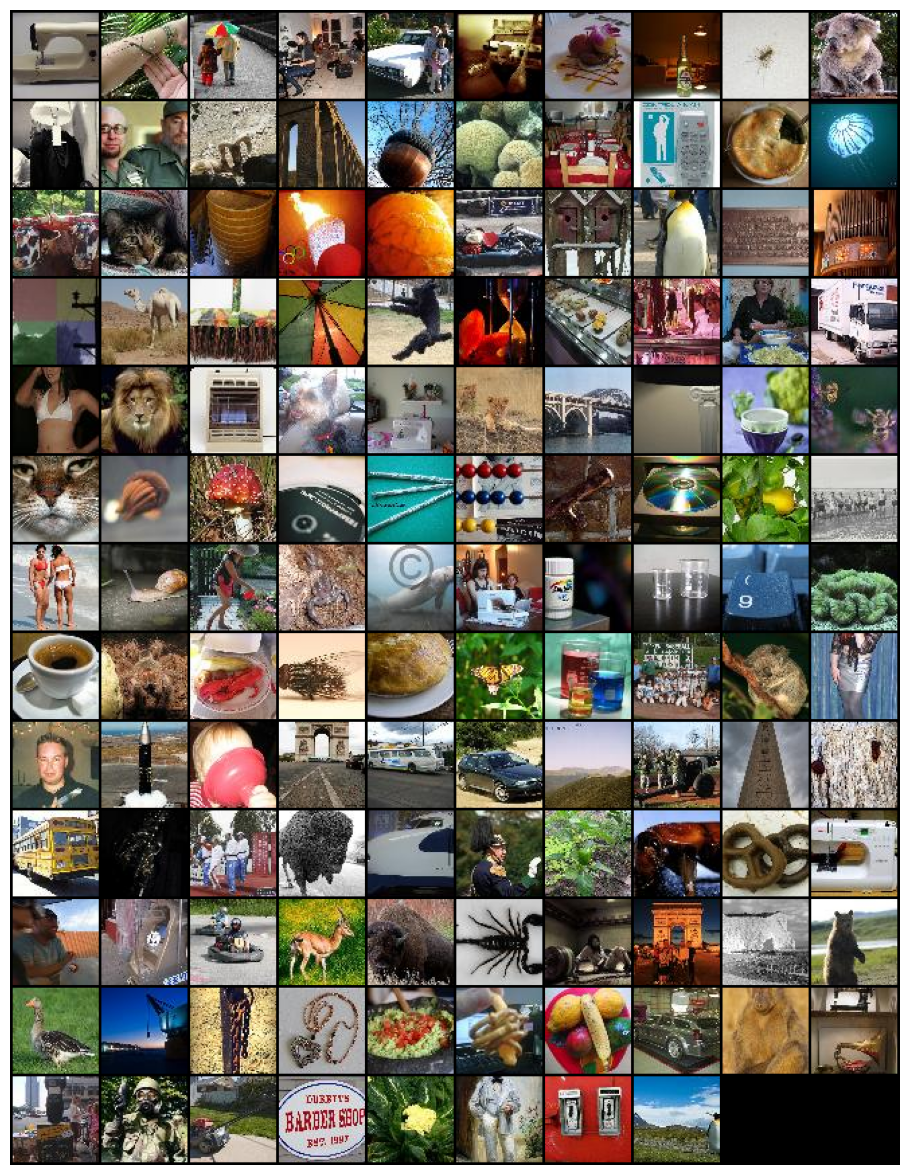

In [ ]:
images, labels = next(iter(train_loader))

class_names = [class_name_mapping[label] for label in labels]

import torchvision
import matplotlib.pyplot as plt
import numpy as np

grid = torchvision.utils.make_grid(images, nrow=10)

=plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print(f"Class names: {class_names}")
plt.axis('off')
plt.show()

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', clean_up_tokenization_spaces=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_encoder = ImageEncoder(embed_size=256).to(device)
text_encoder = TextEncoder(embed_size=256).to(device)

optimizer = torch.optim.Adam(list(image_encoder.parameters()) + list(text_encoder.parameters()), lr=1e-4)

class_name_mapping = load_class_names()

num_epochs = 10
for epoch in range(num_epochs):
    image_encoder.train()
    text_encoder.train()

    running_loss = 0.0
    train_labels, train_preds = [], []

    for images, labels in train_loader:
        images = images.to(device)

        class_names = [class_name_mapping[label] for label in labels]

        image_embeddings = image_encoder(images)

        input_ids, attention_masks = [], []
        for class_name in class_names:
            name_parts = class_name.split(',')
            text = f"A photo of a {name_parts[0]}"

            encoding = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
            input_ids.append(encoding['input_ids'])
            attention_masks.append(encoding['attention_mask'])

        input_ids = torch.cat(input_ids).to(device)
        attention_masks = torch.cat(attention_masks).to(device)

        text_embeddings = text_encoder(input_ids=input_ids, attention_mask=attention_masks)

        loss = contrastive_loss(image_embeddings, text_embeddings)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_preds.append(torch.argmax(image_embeddings, dim=1).cpu().numpy())
        train_labels.append(labels)

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}")

    image_encoder.eval()
    text_encoder.eval()
    val_running_loss = 0.0
    val_labels, val_preds = [], []

    with torch.no_grad():
        for val_images, val_labels_batch in val_loader:
            val_images = val_images.to(device)
            val_class_names = [class_name_mapping[label] for label in val_labels_batch]

            val_image_embeddings = image_encoder(val_images)

            val_input_ids, val_attention_masks = [], []
            for class_name in val_class_names:
                name_parts = class_name.split(',')
                text = f"A photo of a {name_parts[0]}"
                encoding = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
                val_input_ids.append(encoding['input_ids'])
                val_attention_masks.append(encoding['attention_mask'])

            val_input_ids = torch.cat(val_input_ids).to(device)
            val_attention_masks = torch.cat(val_attention_masks).to(device)

            val_text_embeddings = text_encoder(input_ids=val_input_ids, attention_mask=val_attention_masks)
            val_loss = contrastive_loss(val_image_embeddings, val_text_embeddings)
            val_running_loss += val_loss.item()

            val_preds.append(torch.argmax(val_image_embeddings, dim=1).cpu().numpy())
            val_labels.append(val_labels_batch)

    print(f"Validation Loss: {val_running_loss/len(val_loader)}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.4MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch [1/10], Loss: 2.465143755531311
Validation Loss: 2.0026527096511453
Epoch [2/10], Loss: 1.6297664428710938
Validation Loss: 1.9383911744804139
Epoch [3/10], Loss: 1.2217313145637512
Validation Loss: 1.9305437142681923
Epoch [4/10], Loss: 0.921086643409729
Validation Loss: 1.971040636111217
Epoch [5/10], Loss: 0.7200952659606934
Validation Loss: 2.0261461765143522
